In [1]:
import os,sys
import pickle
import math
import numpy as np
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF 
# This needs scipy==1.2.0 
from LambdaData import *

In [2]:
#trace_path = "10-b.pckl"
trace_path = "392-b.pckl"

lambdas, input_trace = pickle.load(open(trace_path, "rb"))
# input_trace : [(LambdaData, time)]

In [3]:
times = np.array([x[1] for x in input_trace])

In [4]:
lam_avg = (times[-1]-times[0])/len(times)
print(lam_avg)

64.0869239420452


In [5]:
iats = np.diff(times)
piats = pd.Series(iats)
moving_iats = piats.rolling(10000).mean()

In [6]:
moving_iats.fillna(method='bfill', inplace=True)

In [7]:
np.mean(iats)

64.08697147859607

In [8]:
ecdf = pickle.load(open("392-b-ecdf.pckl","rb"))

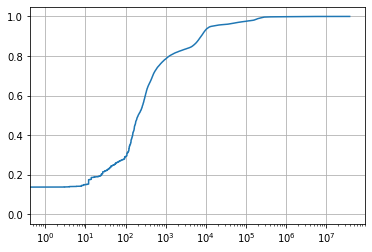

In [9]:
plt.plot(ecdf.x,ecdf.y)
plt.semilogx()
plt.grid()

In [10]:
def find_nearest_idx(array,value):
    idx = np.searchsorted(array, value)
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return int(idx-1)
    else:
        return int(idx)
    
def cache_size_for_HR(ecdf, target):
    cache_size = ecdf.x[find_nearest_idx(ecdf.y, target)]
    return cache_size

def hit_rate(ecdf, cache_size):
    hit_rate = ecdf.y[find_nearest_idx(ecdf.x,cache_size)]
    return hit_rate


In [32]:
def dyn_scale(ecdf, moving_iats):
    prev_index = 0 #When the last change was made. 
    curr_cache_size = 5000 
    max_cache_size = 20000 #eyeballed from the HRC
    target_miss_speed = (1.0/65)*0.1 #10% miss rate 
    print("Target miss speed: ", target_miss_speed)
    curr_hit_rate = hit_rate(ecdf, curr_cache_size)
    miss_speeds_all = [] 
    avg_iat = np.mean(moving_iats)
    updates_times = [0]
    updates_sizes = [curr_cache_size]
    for index, curr_iat in moving_iats.items():
        lam_rate = 1.0/curr_iat 
        # Main problem: At some point we will need real miss-speeds...
        miss_speed =  lam_rate*(1.0-curr_hit_rate)
        miss_speeds_all.append(miss_speed)
        error = miss_speed - target_miss_speed 
        relative_error = error/target_miss_speed 
        if relative_error > 0.3 or relative_error < -0.3 :
            #print("Rel error: {}",relative_error)
            if index - prev_index > 10000 :
                prev_index = index 
                #print("At {}: Miss-speed:{}, relative-error:{}".format(index, miss_speed, relative_error))
                target_miss_rate = (curr_iat/avg_iat)*0.1 # 0.9 is the original target hit-rate... 
                new_cache_size = cache_size_for_HR(ecdf, 1.0-target_miss_rate) 
                
                if math.fabs(new_cache_size-curr_cache_size) > 100: #100 MB atleast.. 
                    
                    new_hit_rate = hit_rate(ecdf, new_cache_size)
                    
                    print("At {}.Relerror:{}. Size from {} to {}, HR from {} to {}".format(index, relative_error, curr_cache_size, 
                                                                    new_cache_size, curr_hit_rate, new_hit_rate))
                    curr_hit_rate = new_hit_rate
                    curr_cache_size = new_cache_size 
                    prev_index = index
                    updates_times.append(index)
                    updates_sizes.append(new_cache_size)
                
    return miss_speeds_all, updates_times, updates_sizes

In [33]:
miss_speeds_all, t, v = dyn_scale(ecdf, moving_iats)

Target miss speed:  0.0015384615384615387
At 286172.Relerror:0.30000623074750293. Size from 5000 to 6871.0, HR from 0.8552190030546896 to 0.8869639396087237
At 350976.Relerror:0.3000861344295086. Size from 6871.0 to 8401.0, HR from 0.8869639396087237 to 0.9117589868717344
At 366556.Relerror:0.3000581041718689. Size from 8401.0 to 9858.0, HR from 0.9117589868717344 to 0.9311158084891518
At 380818.Relerror:-0.30012221590137644. Size from 9858.0 to 7649.0, HR from 0.9311158084891518 to 0.9000796602833898
At 439339.Relerror:0.30006922482279114. Size from 7649.0 to 9088.0, HR from 0.9000796602833898 to 0.921976829520721
At 739271.Relerror:0.3001074904982891. Size from 9088.0 to 10718.0, HR from 0.921976829520721 to 0.9390881092913997
At 1105957.Relerror:-0.30008049679338633. Size from 10718.0 to 8396.0, HR from 0.9390881092913997 to 0.9116774448493667
At 1282823.Relerror:-0.3000089193227235. Size from 8396.0 to 6049.0, HR from 0.9116774448493667 to 0.8719225727135302


[0, 286172, 350976, 366556, 380818, 439339, 739271, 1105957, 1282823, 1348161, 1348161, 1348161, 1348161, 1348161, 1348161, 1348161, 1348161] [5000, 6871.0, 8401.0, 9858.0, 7649.0, 9088.0, 10718.0, 8396.0, 6049.0, 6049.0, 6049.0, 6049.0, 6049.0, 6049.0, 6049.0, 6049.0, 6049.0]


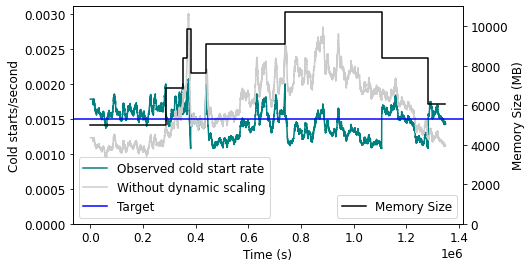

In [41]:
matplotlib.rcParams.update({'font.size': 12})
fig, ax = plt.subplots()
fig.set_size_inches(7, 4)
ax.plot(miss_speeds_all,label="Observed cold start rate",color='teal')
ax.plot([(1.0/x)*0.1 for x in moving_iats], label="Without dynamic scaling",color='0.8')
ax.set_ylabel("Cold starts/second")
ax.set_xlabel("Time (s)")
ax.set_ylim((0))
ax.axhline(0.0015, color='blue', label="Target")
ax2=ax.twinx()
last_t = len(miss_speeds_all)
t.append(last_t) # for the extrapolation
v.append(v[-1]) # for extrapolation
print(t,v)
ax2.step(t,v,color='k',where='post', label="Memory Size")
ax2.set_ylim((0))
ax2.set_ylabel("Memory Size (MB)")
ax.legend(loc='lower left')
ax2.legend(loc='lower right')
plt.savefig("dyn-scale-392-b.pdf",dpi=600, bbox_inches="tight")

In [28]:
v.append(v[-1])
print(v)

[5000, 6871.0, 8401.0, 9858.0, 6691.0, 6691.0, 6691.0]


Text(0, 0.5, 'Server Memory Size (MB)')

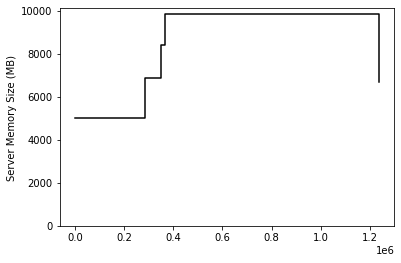

In [17]:
plt.step(t,v, color='k',where='post')
plt.ylim(0)
plt.ylabel("Server Memory Size (MB)")

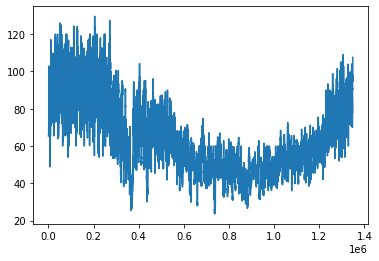

In [124]:
plt.plot(moving_iats)

In [25]:


m_avg = (1-HR[20000])*lam_avg
print(m_avg)

0.7331563020824098


In [30]:
piats = pd.Series(iats)

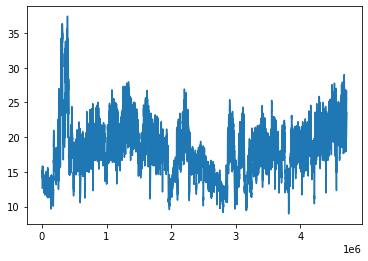

In [36]:
plt.plot(piats.rolling(3600).mean())

In [227]:
def SHARDS_reusedist(input_trace, R=0.01):
    """ R is the sampling rate, like"""
    #hash(k) % P < T
    #R = T/P -> T=0.01P -> P > 100
    P  = 10000 
    T  = int(R*P)
    
    last_access = dict()
    reuse_distances = []
    current_bytes = 0
    
    for i, (d, t) in enumerate(input_trace):
        k = d.kind 
        current_bytes += d.mem_size 
        if hash(k) % P < T: # chosen one 
            #Check if first access? 
            if k in last_access:
                rd = (current_bytes - last_access[k]) - 2.0*d.mem_size 
                # Account for left and right access 
                last_access[k] = current_bytes 
                reuse_distances.append(rd)
            else: # This is first access. 
                last_access[k] = current_bytes 
                #Ignore the reuse distance for the first access? 
    
    reuse_distances = np.array(reuse_distances)
    reuse_distances = reuse_distances*(1/R)
    #print(last_access)
    return reuse_distances
            


In [228]:
srds = SHARDS_reusedist(input_trace,0.1)

In [229]:
srds

array([61670., 67290.,  2050., ..., 63840., 23050., 25840.])

(0.0, 200000.0)

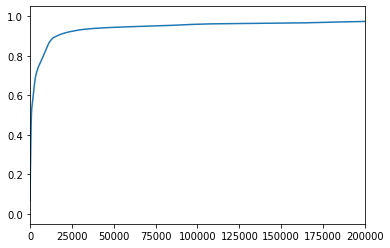

In [236]:
e3=ECDF(srds*0.1)
plt.plot(e3.x,e3.y)
plt.xlim((0,200000))

(array([4.16661e+05, 2.90000e+01, 9.00000e+00, 3.00000e+00, 2.00000e+00,
        3.00000e+00, 3.00000e+00, 1.00000e+00, 1.00000e+00, 2.00000e+00]),
 array([0.00000000e+00, 4.28157599e+08, 8.56315198e+08, 1.28447280e+09,
        1.71263040e+09, 2.14078800e+09, 2.56894559e+09, 2.99710319e+09,
        3.42526079e+09, 3.85341839e+09, 4.28157599e+09]),
 <BarContainer object of 10 artists>)

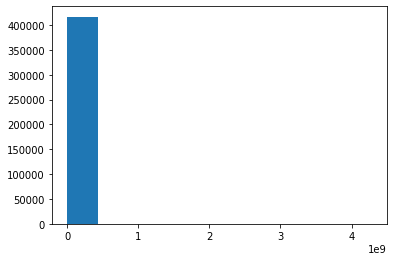

In [221]:
plt.hist(srds)

In [185]:
# a, b, c, b, a
# <----------->
# reuse dist = size of unique accesses
# reuse dist = size(b) + size(c)
N = len(input_trace)

reuse_distances = []
reuse_times = []

for i, (d_left, t_left) in enumerate(input_trace):
    left_kind = d_left.kind
    local_reuse_set = dict()
    
    for j in range(i+1, N):
        d, t = input_trace[j]
        
        if d.kind == left_kind or j == N :
            # We have found the back marker.
            current_rd = sum(local_reuse_set.values()) 
            # TODO: falling of the end
            reuse_distances.append(current_rd)
            reuse_times.append(t-t_left)
            break
        
        # if different from left_kind 
        local_reuse_set[d.kind] = d.mem_size
        
reuse_distances = np.array(reuse_distances)
reuse_times = np.array(reuse_times)

In [186]:
reuse_distances

array([0, 0, 0, ..., 0, 0, 0])

In [188]:
reuse_times

array([ 4000.,  4000.,  4000., ..., 10000., 10000., 10000.])

In [189]:
def hit_rate(cache_size):
    e=ECDF(reuse_distances)
    hit_rate = e.y[find_nearest_idx(e.x,cache_size)]
    return hit_rate

In [190]:
hit_rate(100)

0.9989329539391784

Text(0, 0.5, 'Hit Ratio')

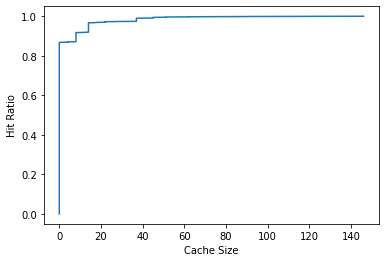

In [191]:
e=ECDF(reuse_distances)
plt.plot(e.x,e.y)
#plt.semilogy()
plt.xlabel("Cache Size")
plt.ylabel("Hit Ratio")

In [15]:
reuse_times[reuse_times>1000]

TypeError: '>' not supported between instances of 'list' and 'int'

In [89]:
et = ECDF(reuse_times)

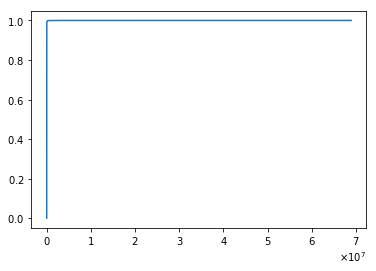

In [90]:
plt.plot(et.x, et.y)

In [8]:
zip(reuse_distances, reuse_times)

In [12]:
import seaborn as sns

/usr/lib/python3/dist-packages/statsmodels/nonparametric/kernels.py:128: RuntimeWarning: divide by zero encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
/usr/lib/python3/dist-packages/statsmodels/nonparametric/kernels.py:128: RuntimeWarning: invalid value encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
/usr/lib/python3/dist-packages/statsmodels/nonparametric/_kernel_base.py:514: RuntimeWarning: invalid value encountered in true_divide
  dens = Kval.prod(axis=1) / np.prod(bw[iscontinuous])
/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:1494: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:1495: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:1130: RuntimeWarning: invalid value 

<AxesSubplot:>

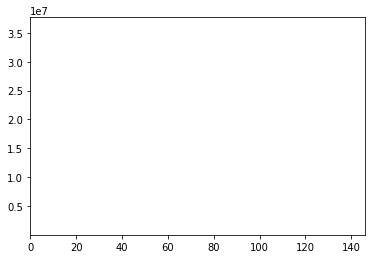

In [27]:
sns.kdeplot(reuse_distances, reuse_times)

(30000, 57907.5049283154)

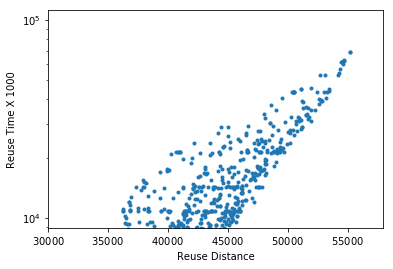

In [92]:
plt.scatter(reuse_distances, reuse_times/1000.0, marker='.')
plt.semilogy()
plt.xlabel("Reuse Distance")
plt.ylabel("Reuse Time X 1000")
plt.xlim((30000))

In [ ]:
# P(s,t) needed for footprint descr
# P(t|s) relatively easier to compute 
# P(s,t) = P(s|t)P(t)
# P(s,t) = P(t|s)P(s)
#P(s|t) = P(t|s)P(s)/P(t) Bayes 

In [36]:
from scipy import stats

In [57]:
xmin, xmax, ymin, ymax = reuse_distances.min(), reuse_distances.max(), reuse_times.min(), reuse_times.max()

In [105]:
kernel = stats.gaussian_kde(np.vstack([reuse_distances, reuse_times]))

In [94]:
kernel.pdf([40,10000])

array([1.43160455e-09])

In [82]:
X,Y=np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

In [83]:
Y.shape

(100, 100)

In [101]:
positions = np.vstack([X.ravel(), Y.ravel()])

In [110]:
kernel([0,1000])

array([3.93083851e-07])

In [139]:
Z = np.reshape(kernel(positions).T, X.shape)

In [115]:
Z = Z/np.max(Z)

(220.5882352925837, 37680000.0)

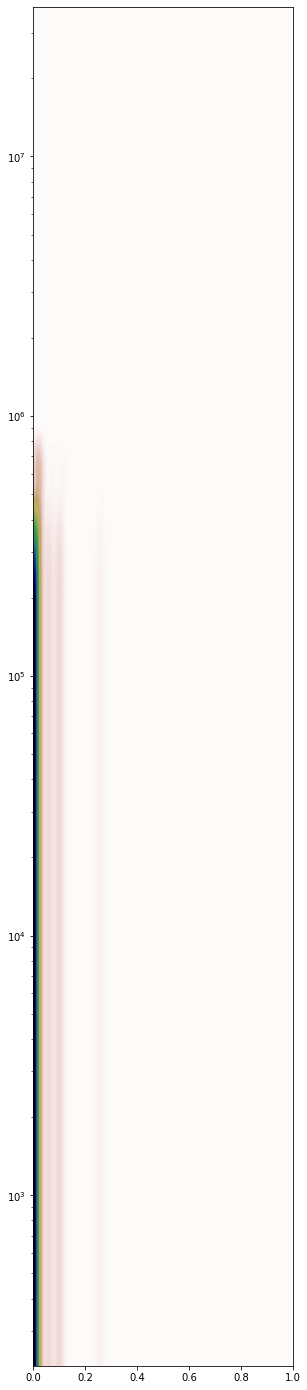

In [141]:
fig, ax = plt.subplots()
fig.set_size_inches((5,25))
ax.imshow(np.rot90(Z), extent=[xmin,1,ymin,ymax],cmap=plt.cm.gist_earth_r)
ax.semilogy()
ax.set_xlim([xmin, 1])
ax.set_ylim([ymin, ymax])

In [53]:
def measure(n):

    "Measurement model, return two coupled measurements."

    m1 = np.random.normal(size=n)

    m2 = np.random.normal(scale=0.5, size=n)

    return m1+m2, m1-m2

In [54]:
m1, m2 = measure(2000)

xmin = m1.min()

xmax = m1.max()

ymin = m2.min()

ymax = m2.max()

In [55]:
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

positions = np.vstack([X.ravel(), Y.ravel()])

values = np.vstack([m1, m2])

kernel = stats.gaussian_kde(values)

Z = np.reshape(kernel(positions).T, X.shape)

(100, 100)